## Pregunta  4

Desde la edad antigua, múltiples formas de localización han sido desarrolladas. Dentro de los avances más importantes en este ámbito, es el desarrollo de la teorı́a cientı́fica y técnica denominada georreferenciación. Gracias a GPS, el crecimiento y acceso de la georreferenciación y navegación está en progresivo aumento, el problema surge cuando se intentan estimar en recintos interiores (como edificios o bajo tierra) donde el GPS no funciona de la manera como uno esperaría, debido a que existen muchos obstáculos e interferencia que imposibilitan su uso.
Dentro de interiores se cuenta con señales RSSI (fingerprint) que pueden atacar este problema, sin embargo los métodos actuales no son robustos a ruido, por lo que su tarea será la de abordar este problema para mejorar exactitud de sistemas de posicionamiento en interiores mediante redes neuronales.

La metodología con la que se trabajará será que, para dentro de interiores, dispositivos Bluetooth emiten señales RSSI las cuales son captadas por el dispositivo "objetivo" al cual se le desea determinar su localización, recibiendo distintas intensidades de señal de cada dispositivo emisor debido a su posición en el interior. Los datos con los que se va a trabajar (IndoorFingerprint.csv) fueron provistos por el nuevo Ing. Civil Informático Felipe Berrios, éstos constan de 8 características (C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI) correspondientes a las mediciones hechas/recibidas por el dispositivo "objetivo" de las distintas señales RSSI emitidas por los dispositivos Bluetooth en los bordes del interior, además de tener la posición del dispositivo "objetivo" en un plano XY (valor a estimar).

Una consideración importante es el cómo tratar la ausencia de la señal proveniente de un dispositivo Bluetooth, para estos datos se utiliza un valor de +100, ya que es imposible obtener este valor debido a las características de la escala RSSI (siempre negativa o igual a cero), pero puede ser sustituido por otro.
Para hacer el trabajo mas simple se discretizará la posición en el plano definiendo zonas en dónde está el objeto a localizar. Las zonas deben ser las que indica la malla a continuación:

In [1]:
from google.colab import files
uploaded = files.upload()

Saving IndoorFingerprint.csv to IndoorFingerprint.csv


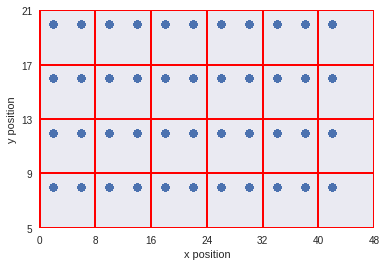

In [2]:
import pandas as pd
import numpy as np

import io #eliminar
df = pd.read_csv(io.StringIO(uploaded["IndoorFingerprint.csv"].decode('utf-8')))#"./IndoorFingerprint.csv")
 
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(df["X"],df["Y"])

x_ticks = np.arange(0, 49, 8)
y_ticks = np.arange(5, 22, 4)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(color='r', linestyle='-', linewidth=2)
plt.ylabel("y position")
plt.xlabel("x position")
plt.show()

Donde los puntos azules son los distintos datos superpuestos de las posiciones del objeto a localizar. Por ejemplo el punto (2,8) está en la primera zona (o en la primera zona del eje x y del eje y), el punto (2,20) está en la zona 19 (o en la primera zona del eje x y la cuarta zona del eje y). Esta discretización transforma el problema que en un principio podría ser de regresión para determinar la posición exacta, en un problema de clasificación dividiendo (dentro de los posibles valores) 6 zonas para el eje "x" y 4 zonas para el eje "y", contando con un total de 24 clases (24 zonas en la malla).



Se entrenará una red feed forward para la clasificación de las 24 posibles clases, donde tal red debe obtener un desempeño (accuracy) mayor al 75%.


A continuación se visualiza un resumen de los datos que se tienen como input, mediante la función *describe*.


In [3]:
print(df.shape)
df.describe()

(6600, 10)


,X,Y,C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI
count,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000
mean,22.000000,14.000000,-71.152121,-85.025909,-89.734545,-77.810758,-90.219091,-80.133030,-89.091515,-89.195455
std,12.650069,4.472475,61.117550,38.743163,7.763426,43.540421,9.230207,7.715085,7.296616,9.508659
min,2.000000,8.000000,-105.000000,-104.000000,-107.000000,-103.000000,-105.000000,-102.000000,-102.000000,-105.000000
25%,10.000000,11.000000,-98.000000,-97.000000,-96.000000,-96.000000,-96.000000,-86.000000,-95.000000,-96.000000
50%,22.000000,14.000000,-93.000000,-94.000000,-92.000000,-87.000000,-91.000000,-80.000000,-90.000000,-90.500000
75%,34.000000,17.000000,-86.000000,-90.000000,-84.000000,-80.000000,-86.000000,-75.000000,-85.000000,-84.000000
max,42.000000,20.000000,100.000000,100.000000,-65.000000,100.000000,100.000000,-57.000000,-60.000000,100.000000


In [4]:
df.head()

,X,Y,C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI
0,2.0,8.0,-66,-92,-84,-84,-92,-93,-98,-96
1,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-96
2,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-100
3,2.0,8.0,-66,-94,-84,-84,-94,-80,-98,-100
4,2.0,8.0,-66,-94,-84,-84,-94,-74,-98,-100


A continuación se genera el conjunto de entrenamiento y de pruebas. Primero se lee el archivo 'mask_test.csv', el cual indica los indices de las posiciones en el dataset que conforman el conjunto de pruebas.

In [4]:
uploaded = files.upload()

Saving mask_test.csv to mask_test.csv


In [0]:
mask_test = np.loadtxt('mask_test.csv',dtype="i")
X = df.as_matrix()
#X_test = X[mask_test]
#X_train = np.delete(X,mask_test,axis=0)

In [6]:
df.shape

(6600, 10)

In [7]:
print(len(X))

6600


Luego, se identifica en qué posición de la grilla se encuentra cada punto, según la variable *X* e *Y* del dataset original, las cuales se comparan con *x_ticks* e *y_ticks*, respectivamente.

In [8]:
np.where(y_ticks>20)[0][0]

4

In [0]:
n = 24
posiciones_grilla = []
for i in X:
  #print(i[0], i[1])
  x = np.where(x_ticks>i[0])[0][0]
  y = np.where(y_ticks>i[1])[0][0]
  posiciones_grilla.append((x,y))

In [10]:
print(posiciones_grilla)

[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1),

Luego, cada posición para el ejemplo entregado es transformado en un one-hot vector, mediante la funcipón *get_dummies* de *pandas*.

In [0]:
y_labels = pd.get_dummies(posiciones_grilla)

In [12]:
print(y_labels.head)
y_labels.tail

<bound method NDFrame.head of       (1, 1)  (1, 2)  (1, 3)  (1, 4)  (2, 1)  (2, 2)  (2, 3)  (2, 4)  (3, 1)  \
0          1       0       0       0       0       0       0       0       0   
1          1       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          1       0       0       0       0       0       0       0       0   
4          1       0       0       0       0       0       0       0       0   
5          1       0       0       0       0       0       0       0       0   
6          1       0       0       0       0       0       0       0       0   
7          1       0       0       0       0       0       0       0       0   
8          1       0       0       0       0       0       0       0       0   
9          1       0       0       0       0       0       0       0       0   
10         1       0       0       0       0       0       0       0       0   
11        

<bound method NDFrame.tail of       (1, 1)  (1, 2)  (1, 3)  (1, 4)  (2, 1)  (2, 2)  (2, 3)  (2, 4)  (3, 1)  \
0          1       0       0       0       0       0       0       0       0   
1          1       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          1       0       0       0       0       0       0       0       0   
4          1       0       0       0       0       0       0       0       0   
5          1       0       0       0       0       0       0       0       0   
6          1       0       0       0       0       0       0       0       0   
7          1       0       0       0       0       0       0       0       0   
8          1       0       0       0       0       0       0       0       0   
9          1       0       0       0       0       0       0       0       0   
10         1       0       0       0       0       0       0       0       0   
11        

Luego, se deben eliminar las columnas *X* e *Y* de los datos, ya que estos indican la posición en el espacio, el cual fue trabajado anteriormente, y corresponde a la etiqueta a predecir, es decir, en qué posición de la grilla estará cierto input. Ahora, después de todo este preprocesamiento de los datos se pueden generar el conjunto de entrenamiento y de prueba.

In [0]:
df.drop(["X","Y"],axis=1,inplace=True)
X = df.as_matrix()
X_test = X[mask_test]
X_train = np.delete(X,mask_test,axis=0)

Y = y_labels.as_matrix()
Y_test = Y[mask_test]
Y_train = np.delete(Y,mask_test,axis=0)

In [14]:
print(len(X_train)+len(X_test))
print(len(Y_train)+len(Y_test))

6600
6600


Como se vio anteriormente todos los datos viven en diferentes rangos y con distintas estadísticas como media y varianza, lo cual podría traer problemas numéricos. Por lo tanto, se normaliza el conjunto de input de enrenamiento y de prueba.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
scaler_test = StandardScaler().fit(X_test)
X_test_scaled = scaler_test.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model
from keras.models import load_model

In [34]:
print(X_train.shape)

(4620, 8)


 A continuación se entrega una red neuronal feed forward:
 * Primera capa: 200 neuronas
 * Primera capa oculta: 400 neuronas
 * Segunda capa oculta: 200 neuronas 
 * Capa de salida: 24 neuronas
 * Función de activación ReLU, excepto para la capa de salida que es Softmax
 * Inicialización de pesos: uniforme
 * Función de pérdida: Categorical cross entropy
 * Optimizador: SGD
 * Tasa de aprendizaje: 0.001
 * Epochs: 300

In [20]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dense(400, kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dense(24, activation='softmax'))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               1800      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               80400     
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               80200     
_________________________________________________________________
activation_3 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                4824      
Total para

In [0]:
sgd = SGD(lr=0.001)
model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['acc'])

In [22]:
model_fit = model.fit(X_train_scaled, Y_train, epochs=300, verbose=1, validation_data=(X_test_scaled, Y_test), shuffle=True)

Train on 4620 samples, validate on 1980 samples
Epoch 1/300
4620/4620 [==============================] - 2s 401us/step - loss: 3.1769 - acc: 0.0288 - val_loss: 3.1749 - val_acc: 0.0424
Epoch 2/300
4620/4620 [==============================] - 1s 178us/step - loss: 3.1730 - acc: 0.0792 - val_loss: 3.1710 - val_acc: 0.0894
Epoch 3/300
4620/4620 [==============================] - 1s 204us/step - loss: 3.1690 - acc: 0.1435 - val_loss: 3.1671 - val_acc: 0.1540
Epoch 4/300
4620/4620 [==============================] - 1s 200us/step - loss: 3.1652 - acc: 0.1764 - val_loss: 3.1634 - val_acc: 0.1793
Epoch 5/300
4620/4620 [==============================] - 1s 200us/step - loss: 3.1615 - acc: 0.2028 - val_loss: 3.1598 - val_acc: 0.2076
Epoch 6/300
4620/4620 [==============================] - 1s 202us/step - loss: 3.1580 - acc: 0.2273 - val_loss: 3.1564 - val_acc: 0.2247
Epoch 7/300
4620/4620 [==============================] - 1s 201us/step - loss: 3.1547 - acc: 0.2377 - val_loss: 3.1530 - val_acc: 

4620/4620 [==============================] - 1s 201us/step - loss: 3.1481 - acc: 0.2485 - val_loss: 3.1465 - val_acc: 0.2328
Epoch 10/300
4620/4620 [==============================] - 1s 201us/step - loss: 3.1448 - acc: 0.2474 - val_loss: 3.1432 - val_acc: 0.2323
Epoch 11/300
4620/4620 [==============================] - 1s 206us/step - loss: 3.1415 - acc: 0.2481 - val_loss: 3.1398 - val_acc: 0.2328
Epoch 12/300
4620/4620 [==============================] - 1s 202us/step - loss: 3.1381 - acc: 0.2474 - val_loss: 3.1364 - val_acc: 0.2364
Epoch 13/300
4620/4620 [==============================] - 1s 203us/step - loss: 3.1347 - acc: 0.2513 - val_loss: 3.1329 - val_acc: 0.2354
Epoch 14/300
4620/4620 [==============================] - 1s 204us/step - loss: 3.1312 - acc: 0.2541 - val_loss: 3.1294 - val_acc: 0.2379
Epoch 15/300
4620/4620 [==============================] - 1s 208us/step - loss: 3.1276 - acc: 0.2545 - val_loss: 3.1257 - val_acc: 0.2424
Epoch 16/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 205us/step - loss: 3.1163 - acc: 0.2684 - val_loss: 3.1143 - val_acc: 0.2581
Epoch 19/300
4620/4620 [==============================] - 1s 198us/step - loss: 3.1123 - acc: 0.2779 - val_loss: 3.1102 - val_acc: 0.2626
Epoch 20/300
4620/4620 [==============================] - 1s 206us/step - loss: 3.1083 - acc: 0.2851 - val_loss: 3.1061 - val_acc: 0.2737
Epoch 21/300
4620/4620 [==============================] - 1s 199us/step - loss: 3.1041 - acc: 0.2961 - val_loss: 3.1018 - val_acc: 0.2823
Epoch 22/300
4620/4620 [==============================] - 1s 199us/step - loss: 3.0997 - acc: 0.3054 - val_loss: 3.0974 - val_acc: 0.2929
Epoch 23/300
4620/4620 [==============================] - 1s 196us/step - loss: 3.0953 - acc: 0.3160 - val_loss: 3.0929 - val_acc: 0.3056
Epoch 24/300
4620/4620 [==============================] - 1s 202us/step - loss: 3.0907 - acc: 0.3227 - val_loss: 3.0883 - val_acc: 0.3131
Epoch 25/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 199us/step - loss: 3.0760 - acc: 0.3422 - val_loss: 3.0734 - val_acc: 0.3237
Epoch 28/300
4620/4620 [==============================] - 1s 201us/step - loss: 3.0708 - acc: 0.3420 - val_loss: 3.0680 - val_acc: 0.3258
Epoch 29/300
4620/4620 [==============================] - 1s 202us/step - loss: 3.0654 - acc: 0.3448 - val_loss: 3.0624 - val_acc: 0.3288
Epoch 30/300
4620/4620 [==============================] - 1s 199us/step - loss: 3.0597 - acc: 0.3496 - val_loss: 3.0567 - val_acc: 0.3323
Epoch 31/300
4620/4620 [==============================] - 1s 201us/step - loss: 3.0538 - acc: 0.3522 - val_loss: 3.0507 - val_acc: 0.3354
Epoch 32/300
4620/4620 [==============================] - 1s 199us/step - loss: 3.0477 - acc: 0.3545 - val_loss: 3.0444 - val_acc: 0.3384
Epoch 33/300
4620/4620 [==============================] - 1s 200us/step - loss: 3.0413 - acc: 0.3576 - val_loss: 3.0379 - val_acc: 0.3419
Epoch 34/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 203us/step - loss: 3.0204 - acc: 0.3628 - val_loss: 3.0166 - val_acc: 0.3470
Epoch 37/300
4620/4620 [==============================] - 1s 199us/step - loss: 3.0128 - acc: 0.3641 - val_loss: 3.0088 - val_acc: 0.3505
Epoch 38/300
4620/4620 [==============================] - 1s 204us/step - loss: 3.0049 - acc: 0.3665 - val_loss: 3.0007 - val_acc: 0.3510
Epoch 39/300
4620/4620 [==============================] - 1s 196us/step - loss: 2.9965 - acc: 0.3682 - val_loss: 2.9922 - val_acc: 0.3520
Epoch 40/300
4620/4620 [==============================] - 1s 199us/step - loss: 2.9878 - acc: 0.3706 - val_loss: 2.9832 - val_acc: 0.3540
Epoch 41/300
4620/4620 [==============================] - 1s 201us/step - loss: 2.9786 - acc: 0.3699 - val_loss: 2.9738 - val_acc: 0.3551
Epoch 42/300
4620/4620 [==============================] - 1s 200us/step - loss: 2.9689 - acc: 0.3703 - val_loss: 2.9639 - val_acc: 0.3540
Epoch 43/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 199us/step - loss: 2.9370 - acc: 0.3699 - val_loss: 2.9313 - val_acc: 0.3571
Epoch 46/300
4620/4620 [==============================] - 1s 197us/step - loss: 2.9253 - acc: 0.3708 - val_loss: 2.9194 - val_acc: 0.3581
Epoch 47/300
4620/4620 [==============================] - 1s 198us/step - loss: 2.9131 - acc: 0.3703 - val_loss: 2.9069 - val_acc: 0.3561
Epoch 48/300
4620/4620 [==============================] - 1s 202us/step - loss: 2.9002 - acc: 0.3688 - val_loss: 2.8937 - val_acc: 0.3545
Epoch 49/300
4620/4620 [==============================] - 1s 199us/step - loss: 2.8866 - acc: 0.3671 - val_loss: 2.8799 - val_acc: 0.3566
Epoch 50/300
4620/4620 [==============================] - 1s 204us/step - loss: 2.8725 - acc: 0.3654 - val_loss: 2.8655 - val_acc: 0.3556
Epoch 51/300
4620/4620 [==============================] - 1s 202us/step - loss: 2.8576 - acc: 0.3654 - val_loss: 2.8503 - val_acc: 0.3525
Epoch 52/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 203us/step - loss: 2.8086 - acc: 0.3617 - val_loss: 2.8005 - val_acc: 0.3475
Epoch 55/300
4620/4620 [==============================] - 1s 202us/step - loss: 2.7909 - acc: 0.3613 - val_loss: 2.7825 - val_acc: 0.3460
Epoch 56/300
4620/4620 [==============================] - 1s 198us/step - loss: 2.7724 - acc: 0.3602 - val_loss: 2.7638 - val_acc: 0.3449
Epoch 57/300
4620/4620 [==============================] - 1s 202us/step - loss: 2.7533 - acc: 0.3587 - val_loss: 2.7445 - val_acc: 0.3419
Epoch 58/300
4620/4620 [==============================] - 1s 197us/step - loss: 2.7335 - acc: 0.3580 - val_loss: 2.7245 - val_acc: 0.3424
Epoch 59/300
4620/4620 [==============================] - 1s 200us/step - loss: 2.7131 - acc: 0.3582 - val_loss: 2.7039 - val_acc: 0.3409
Epoch 60/300
4620/4620 [==============================] - 1s 195us/step - loss: 2.6921 - acc: 0.3571 - val_loss: 2.6828 - val_acc: 0.3409
Epoch 61/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 198us/step - loss: 2.6258 - acc: 0.3569 - val_loss: 2.6162 - val_acc: 0.3414
Epoch 64/300
4620/4620 [==============================] - 1s 202us/step - loss: 2.6027 - acc: 0.3574 - val_loss: 2.5929 - val_acc: 0.3414
Epoch 65/300
4620/4620 [==============================] - 1s 197us/step - loss: 2.5791 - acc: 0.3600 - val_loss: 2.5693 - val_acc: 0.3409
Epoch 66/300
4620/4620 [==============================] - 1s 200us/step - loss: 2.5551 - acc: 0.3630 - val_loss: 2.5453 - val_acc: 0.3424
Epoch 67/300
4620/4620 [==============================] - 1s 201us/step - loss: 2.5308 - acc: 0.3654 - val_loss: 2.5210 - val_acc: 0.3465
Epoch 68/300
4620/4620 [==============================] - 1s 204us/step - loss: 2.5062 - acc: 0.3690 - val_loss: 2.4963 - val_acc: 0.3485
Epoch 69/300
4620/4620 [==============================] - 1s 199us/step - loss: 2.4812 - acc: 0.3688 - val_loss: 2.4712 - val_acc: 0.3535
Epoch 70/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 201us/step - loss: 2.4049 - acc: 0.3857 - val_loss: 2.3946 - val_acc: 0.3742
Epoch 73/300
4620/4620 [==============================] - 1s 196us/step - loss: 2.3790 - acc: 0.3937 - val_loss: 2.3686 - val_acc: 0.3818
Epoch 74/300
4620/4620 [==============================] - 1s 204us/step - loss: 2.3530 - acc: 0.4009 - val_loss: 2.3425 - val_acc: 0.3879
Epoch 75/300
4620/4620 [==============================] - 1s 197us/step - loss: 2.3269 - acc: 0.4097 - val_loss: 2.3163 - val_acc: 0.3970
Epoch 76/300
4620/4620 [==============================] - 1s 202us/step - loss: 2.3008 - acc: 0.4158 - val_loss: 2.2900 - val_acc: 0.4045
Epoch 77/300
4620/4620 [==============================] - 1s 198us/step - loss: 2.2746 - acc: 0.4221 - val_loss: 2.2637 - val_acc: 0.4081
Epoch 78/300
4620/4620 [==============================] - 1s 200us/step - loss: 2.2485 - acc: 0.4286 - val_loss: 2.2374 - val_acc: 0.4141
Epoch 79/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 197us/step - loss: 2.1700 - acc: 0.4416 - val_loss: 2.1582 - val_acc: 0.4313
Epoch 82/300
4620/4620 [==============================] - 1s 197us/step - loss: 2.1438 - acc: 0.4448 - val_loss: 2.1319 - val_acc: 0.4328
Epoch 83/300
4620/4620 [==============================] - 1s 201us/step - loss: 2.1178 - acc: 0.4537 - val_loss: 2.1057 - val_acc: 0.4434
Epoch 84/300
4620/4620 [==============================] - 1s 198us/step - loss: 2.0919 - acc: 0.4595 - val_loss: 2.0796 - val_acc: 0.4515
Epoch 85/300
4620/4620 [==============================] - 1s 201us/step - loss: 2.0662 - acc: 0.4643 - val_loss: 2.0536 - val_acc: 0.4556
Epoch 86/300
4620/4620 [==============================] - 1s 199us/step - loss: 2.0407 - acc: 0.4747 - val_loss: 2.0278 - val_acc: 0.4601
Epoch 87/300
4620/4620 [==============================] - 1s 196us/step - loss: 2.0153 - acc: 0.4835 - val_loss: 2.0022 - val_acc: 0.4773
Epoch 88/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 196us/step - loss: 1.9404 - acc: 0.4987 - val_loss: 1.9264 - val_acc: 0.4995
Epoch 91/300
4620/4620 [==============================] - 1s 200us/step - loss: 1.9158 - acc: 0.5106 - val_loss: 1.9015 - val_acc: 0.5061
Epoch 92/300
4620/4620 [==============================] - 1s 199us/step - loss: 1.8914 - acc: 0.5147 - val_loss: 1.8768 - val_acc: 0.5253
Epoch 93/300
4620/4620 [==============================] - 1s 195us/step - loss: 1.8672 - acc: 0.5310 - val_loss: 1.8523 - val_acc: 0.5298
Epoch 94/300
4620/4620 [==============================] - 1s 198us/step - loss: 1.8432 - acc: 0.5392 - val_loss: 1.8280 - val_acc: 0.5348
Epoch 95/300
4620/4620 [==============================] - 1s 205us/step - loss: 1.8195 - acc: 0.5374 - val_loss: 1.8040 - val_acc: 0.5404
Epoch 96/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.7962 - acc: 0.5407 - val_loss: 1.7804 - val_acc: 0.5429
Epoch 97/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 200us/step - loss: 1.7280 - acc: 0.5511 - val_loss: 1.7115 - val_acc: 0.5551
Epoch 100/300
4620/4620 [==============================] - 1s 201us/step - loss: 1.7061 - acc: 0.5517 - val_loss: 1.6894 - val_acc: 0.5586
Epoch 101/300
4620/4620 [==============================] - 1s 199us/step - loss: 1.6845 - acc: 0.5535 - val_loss: 1.6676 - val_acc: 0.5631
Epoch 102/300
4620/4620 [==============================] - 1s 199us/step - loss: 1.6634 - acc: 0.5563 - val_loss: 1.6462 - val_acc: 0.5677
Epoch 103/300
4620/4620 [==============================] - 1s 206us/step - loss: 1.6426 - acc: 0.5593 - val_loss: 1.6253 - val_acc: 0.5667
Epoch 104/300
4620/4620 [==============================] - 1s 202us/step - loss: 1.6223 - acc: 0.5623 - val_loss: 1.6049 - val_acc: 0.5702
Epoch 105/300
4620/4620 [==============================] - 1s 202us/step - loss: 1.6026 - acc: 0.5660 - val_loss: 1.5850 - val_acc: 0.5742
Epoch 106/300
4620/4620 [================

4620/4620 [==============================] - 1s 202us/step - loss: 1.5461 - acc: 0.5801 - val_loss: 1.5280 - val_acc: 0.5828
Epoch 109/300
4620/4620 [==============================] - 1s 197us/step - loss: 1.5283 - acc: 0.5792 - val_loss: 1.5099 - val_acc: 0.5874
Epoch 110/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.5108 - acc: 0.5840 - val_loss: 1.4922 - val_acc: 0.5924
Epoch 111/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.4938 - acc: 0.5896 - val_loss: 1.4753 - val_acc: 0.5909
Epoch 112/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.4772 - acc: 0.5922 - val_loss: 1.4585 - val_acc: 0.5934
Epoch 113/300
4620/4620 [==============================] - 1s 201us/step - loss: 1.4612 - acc: 0.5952 - val_loss: 1.4424 - val_acc: 0.5960
Epoch 114/300
4620/4620 [==============================] - 1s 198us/step - loss: 1.4454 - acc: 0.5968 - val_loss: 1.4265 - val_acc: 0.6000
Epoch 115/300
4620/4620 [================

4620/4620 [==============================] - 1s 199us/step - loss: 1.4004 - acc: 0.6078 - val_loss: 1.3815 - val_acc: 0.6035
Epoch 118/300
4620/4620 [==============================] - 1s 198us/step - loss: 1.3861 - acc: 0.6061 - val_loss: 1.3676 - val_acc: 0.6076
Epoch 119/300
4620/4620 [==============================] - 1s 204us/step - loss: 1.3723 - acc: 0.6117 - val_loss: 1.3542 - val_acc: 0.6121
Epoch 120/300
4620/4620 [==============================] - 1s 202us/step - loss: 1.3588 - acc: 0.6130 - val_loss: 1.3405 - val_acc: 0.6177
Epoch 121/300
4620/4620 [==============================] - 1s 207us/step - loss: 1.3457 - acc: 0.6132 - val_loss: 1.3275 - val_acc: 0.6222
Epoch 122/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.3329 - acc: 0.6210 - val_loss: 1.3147 - val_acc: 0.6212
Epoch 123/300
4620/4620 [==============================] - 1s 196us/step - loss: 1.3205 - acc: 0.6212 - val_loss: 1.3020 - val_acc: 0.6247
Epoch 124/300
4620/4620 [================

4620/4620 [==============================] - 1s 199us/step - loss: 1.2850 - acc: 0.6301 - val_loss: 1.2659 - val_acc: 0.6348
Epoch 127/300
4620/4620 [==============================] - 1s 195us/step - loss: 1.2737 - acc: 0.6303 - val_loss: 1.2551 - val_acc: 0.6414
Epoch 128/300
4620/4620 [==============================] - 1s 196us/step - loss: 1.2627 - acc: 0.6364 - val_loss: 1.2437 - val_acc: 0.6434
Epoch 129/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.2521 - acc: 0.6379 - val_loss: 1.2329 - val_acc: 0.6500
Epoch 130/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.2412 - acc: 0.6446 - val_loss: 1.2217 - val_acc: 0.6485
Epoch 131/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.2303 - acc: 0.6474 - val_loss: 1.2112 - val_acc: 0.6535
Epoch 132/300
4620/4620 [==============================] - 1s 204us/step - loss: 1.2197 - acc: 0.6463 - val_loss: 1.2007 - val_acc: 0.6616
Epoch 133/300
4620/4620 [================

Epoch 135/300
4620/4620 [==============================] - 1s 202us/step - loss: 1.1893 - acc: 0.6556 - val_loss: 1.1705 - val_acc: 0.6682
Epoch 136/300
4620/4620 [==============================] - 1s 201us/step - loss: 1.1796 - acc: 0.6558 - val_loss: 1.1613 - val_acc: 0.6682
Epoch 137/300
4620/4620 [==============================] - 1s 201us/step - loss: 1.1702 - acc: 0.6589 - val_loss: 1.1525 - val_acc: 0.6737
Epoch 138/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.1609 - acc: 0.6662 - val_loss: 1.1434 - val_acc: 0.6727
Epoch 139/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.1520 - acc: 0.6688 - val_loss: 1.1343 - val_acc: 0.6793
Epoch 140/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.1431 - acc: 0.6710 - val_loss: 1.1258 - val_acc: 0.6783
Epoch 141/300
4620/4620 [==============================] - 1s 196us/step - loss: 1.1343 - acc: 0.6695 - val_loss: 1.1166 - val_acc: 0.6793
Epoch 142/300
4620/4620 [==

4620/4620 [==============================] - 1s 198us/step - loss: 1.1093 - acc: 0.6797 - val_loss: 1.0926 - val_acc: 0.6854
Epoch 145/300
4620/4620 [==============================] - 1s 195us/step - loss: 1.1012 - acc: 0.6788 - val_loss: 1.0850 - val_acc: 0.6889
Epoch 146/300
4620/4620 [==============================] - 1s 215us/step - loss: 1.0932 - acc: 0.6857 - val_loss: 1.0777 - val_acc: 0.6904
Epoch 147/300
4620/4620 [==============================] - 1s 199us/step - loss: 1.0855 - acc: 0.6846 - val_loss: 1.0695 - val_acc: 0.6919
Epoch 148/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.0779 - acc: 0.6859 - val_loss: 1.0619 - val_acc: 0.6899
Epoch 149/300
4620/4620 [==============================] - 1s 199us/step - loss: 1.0704 - acc: 0.6892 - val_loss: 1.0547 - val_acc: 0.6914
Epoch 150/300
4620/4620 [==============================] - 1s 197us/step - loss: 1.0631 - acc: 0.6924 - val_loss: 1.0480 - val_acc: 0.6949
Epoch 151/300
4620/4620 [================

4620/4620 [==============================] - 1s 201us/step - loss: 1.0417 - acc: 0.6981 - val_loss: 1.0269 - val_acc: 0.7000
Epoch 154/300
4620/4620 [==============================] - 1s 200us/step - loss: 1.0348 - acc: 0.6976 - val_loss: 1.0212 - val_acc: 0.7025
Epoch 155/300
4620/4620 [==============================] - 1s 202us/step - loss: 1.0282 - acc: 0.7017 - val_loss: 1.0141 - val_acc: 0.7045
Epoch 156/300
4620/4620 [==============================] - 1s 202us/step - loss: 1.0216 - acc: 0.7054 - val_loss: 1.0079 - val_acc: 0.7025
Epoch 157/300
4620/4620 [==============================] - 1s 203us/step - loss: 1.0150 - acc: 0.7052 - val_loss: 1.0015 - val_acc: 0.7076
Epoch 158/300
4620/4620 [==============================] - 1s 193us/step - loss: 1.0087 - acc: 0.7052 - val_loss: 0.9954 - val_acc: 0.7121
Epoch 159/300
4620/4620 [==============================] - 1s 196us/step - loss: 1.0024 - acc: 0.7065 - val_loss: 0.9897 - val_acc: 0.7101
Epoch 160/300
4620/4620 [================

4620/4620 [==============================] - 1s 194us/step - loss: 0.9843 - acc: 0.7147 - val_loss: 0.9722 - val_acc: 0.7192
Epoch 163/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.9782 - acc: 0.7165 - val_loss: 0.9668 - val_acc: 0.7222
Epoch 164/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.9724 - acc: 0.7152 - val_loss: 0.9614 - val_acc: 0.7258
Epoch 165/300
4620/4620 [==============================] - 1s 204us/step - loss: 0.9669 - acc: 0.7214 - val_loss: 0.9555 - val_acc: 0.7288
Epoch 166/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.9611 - acc: 0.7210 - val_loss: 0.9510 - val_acc: 0.7343
Epoch 167/300
4620/4620 [==============================] - 1s 196us/step - loss: 0.9557 - acc: 0.7247 - val_loss: 0.9454 - val_acc: 0.7298
Epoch 168/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.9504 - acc: 0.7279 - val_loss: 0.9401 - val_acc: 0.7247
Epoch 169/300
4620/4620 [================

4620/4620 [==============================] - 1s 199us/step - loss: 0.9346 - acc: 0.7279 - val_loss: 0.9251 - val_acc: 0.7308
Epoch 172/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.9296 - acc: 0.7297 - val_loss: 0.9198 - val_acc: 0.7338
Epoch 173/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.9245 - acc: 0.7312 - val_loss: 0.9157 - val_acc: 0.7333
Epoch 174/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.9197 - acc: 0.7320 - val_loss: 0.9110 - val_acc: 0.7369
Epoch 175/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.9148 - acc: 0.7323 - val_loss: 0.9070 - val_acc: 0.7389
Epoch 176/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.9102 - acc: 0.7351 - val_loss: 0.9023 - val_acc: 0.7399
Epoch 177/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.9053 - acc: 0.7383 - val_loss: 0.8981 - val_acc: 0.7354
Epoch 178/300
4620/4620 [================

4620/4620 [==============================] - 1s 204us/step - loss: 0.8917 - acc: 0.7398 - val_loss: 0.8844 - val_acc: 0.7439
Epoch 181/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.8871 - acc: 0.7409 - val_loss: 0.8810 - val_acc: 0.7434
Epoch 182/300
4620/4620 [==============================] - 1s 194us/step - loss: 0.8827 - acc: 0.7431 - val_loss: 0.8765 - val_acc: 0.7455
Epoch 183/300
4620/4620 [==============================] - 1s 195us/step - loss: 0.8785 - acc: 0.7429 - val_loss: 0.8726 - val_acc: 0.7505
Epoch 184/300
4620/4620 [==============================] - 1s 194us/step - loss: 0.8742 - acc: 0.7442 - val_loss: 0.8684 - val_acc: 0.7530
Epoch 185/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.8701 - acc: 0.7455 - val_loss: 0.8641 - val_acc: 0.7510
Epoch 186/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.8660 - acc: 0.7485 - val_loss: 0.8611 - val_acc: 0.7510
Epoch 187/300
4620/4620 [================

4620/4620 [==============================] - 1s 196us/step - loss: 0.8540 - acc: 0.7511 - val_loss: 0.8493 - val_acc: 0.7596
Epoch 190/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.8500 - acc: 0.7509 - val_loss: 0.8464 - val_acc: 0.7571
Epoch 191/300
4620/4620 [==============================] - 1s 197us/step - loss: 0.8464 - acc: 0.7545 - val_loss: 0.8425 - val_acc: 0.7571
Epoch 192/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.8424 - acc: 0.7539 - val_loss: 0.8392 - val_acc: 0.7626
Epoch 193/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.8388 - acc: 0.7532 - val_loss: 0.8363 - val_acc: 0.7606
Epoch 194/300
4620/4620 [==============================] - 1s 206us/step - loss: 0.8350 - acc: 0.7563 - val_loss: 0.8325 - val_acc: 0.7606
Epoch 195/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.8315 - acc: 0.7567 - val_loss: 0.8294 - val_acc: 0.7606
Epoch 196/300
4620/4620 [================

4620/4620 [==============================] - 1s 195us/step - loss: 0.8208 - acc: 0.7589 - val_loss: 0.8195 - val_acc: 0.7611
Epoch 199/300
4620/4620 [==============================] - 1s 196us/step - loss: 0.8174 - acc: 0.7613 - val_loss: 0.8155 - val_acc: 0.7657
Epoch 200/300
4620/4620 [==============================] - 1s 196us/step - loss: 0.8140 - acc: 0.7593 - val_loss: 0.8122 - val_acc: 0.7652
Epoch 201/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.8106 - acc: 0.7619 - val_loss: 0.8098 - val_acc: 0.7641
Epoch 202/300
4620/4620 [==============================] - 1s 196us/step - loss: 0.8073 - acc: 0.7619 - val_loss: 0.8066 - val_acc: 0.7641
Epoch 203/300
4620/4620 [==============================] - 1s 205us/step - loss: 0.8041 - acc: 0.7647 - val_loss: 0.8035 - val_acc: 0.7667
Epoch 204/300
4620/4620 [==============================] - 1s 206us/step - loss: 0.8008 - acc: 0.7606 - val_loss: 0.7999 - val_acc: 0.7677
Epoch 205/300
4620/4620 [================

4620/4620 [==============================] - 1s 201us/step - loss: 0.7915 - acc: 0.7660 - val_loss: 0.7916 - val_acc: 0.7722
Epoch 208/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.7882 - acc: 0.7660 - val_loss: 0.7897 - val_acc: 0.7707
Epoch 209/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.7853 - acc: 0.7671 - val_loss: 0.7870 - val_acc: 0.7697
Epoch 210/300
4620/4620 [==============================] - 1s 204us/step - loss: 0.7821 - acc: 0.7686 - val_loss: 0.7840 - val_acc: 0.7712
Epoch 211/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.7790 - acc: 0.7686 - val_loss: 0.7812 - val_acc: 0.7712
Epoch 212/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.7761 - acc: 0.7712 - val_loss: 0.7780 - val_acc: 0.7712
Epoch 213/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.7734 - acc: 0.7695 - val_loss: 0.7756 - val_acc: 0.7727
Epoch 214/300
4620/4620 [================

4620/4620 [==============================] - 1s 202us/step - loss: 0.7646 - acc: 0.7727 - val_loss: 0.7678 - val_acc: 0.7768
Epoch 217/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.7618 - acc: 0.7734 - val_loss: 0.7644 - val_acc: 0.7788
Epoch 218/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.7591 - acc: 0.7729 - val_loss: 0.7617 - val_acc: 0.7747
Epoch 219/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.7563 - acc: 0.7755 - val_loss: 0.7597 - val_acc: 0.7758
Epoch 220/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.7535 - acc: 0.7764 - val_loss: 0.7585 - val_acc: 0.7753
Epoch 221/300
4620/4620 [==============================] - 1s 197us/step - loss: 0.7507 - acc: 0.7786 - val_loss: 0.7547 - val_acc: 0.7828
Epoch 222/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.7485 - acc: 0.7784 - val_loss: 0.7536 - val_acc: 0.7803
Epoch 223/300
4620/4620 [================

4620/4620 [==============================] - 1s 202us/step - loss: 0.7406 - acc: 0.7805 - val_loss: 0.7454 - val_acc: 0.7823
Epoch 226/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.7381 - acc: 0.7814 - val_loss: 0.7439 - val_acc: 0.7828
Epoch 227/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.7357 - acc: 0.7805 - val_loss: 0.7402 - val_acc: 0.7854
Epoch 228/300
4620/4620 [==============================] - 1s 204us/step - loss: 0.7331 - acc: 0.7829 - val_loss: 0.7381 - val_acc: 0.7854
Epoch 229/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.7306 - acc: 0.7818 - val_loss: 0.7360 - val_acc: 0.7833
Epoch 230/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.7281 - acc: 0.7842 - val_loss: 0.7346 - val_acc: 0.7833
Epoch 231/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.7259 - acc: 0.7851 - val_loss: 0.7318 - val_acc: 0.7833
Epoch 232/300
4620/4620 [================

4620/4620 [==============================] - 1s 202us/step - loss: 0.7185 - acc: 0.7861 - val_loss: 0.7263 - val_acc: 0.7864
Epoch 235/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.7166 - acc: 0.7885 - val_loss: 0.7240 - val_acc: 0.7848
Epoch 236/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.7141 - acc: 0.7846 - val_loss: 0.7212 - val_acc: 0.7879
Epoch 237/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.7119 - acc: 0.7853 - val_loss: 0.7190 - val_acc: 0.7904
Epoch 238/300
4620/4620 [==============================] - 1s 205us/step - loss: 0.7099 - acc: 0.7872 - val_loss: 0.7166 - val_acc: 0.7869
Epoch 239/300
4620/4620 [==============================] - 1s 204us/step - loss: 0.7074 - acc: 0.7900 - val_loss: 0.7158 - val_acc: 0.7894
Epoch 240/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.7053 - acc: 0.7887 - val_loss: 0.7131 - val_acc: 0.7874
Epoch 241/300
4620/4620 [================

4620/4620 [==============================] - 1s 202us/step - loss: 0.6986 - acc: 0.7911 - val_loss: 0.7080 - val_acc: 0.7899
Epoch 244/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.6965 - acc: 0.7926 - val_loss: 0.7046 - val_acc: 0.7914
Epoch 245/300
4620/4620 [==============================] - 1s 203us/step - loss: 0.6944 - acc: 0.7892 - val_loss: 0.7036 - val_acc: 0.7899
Epoch 246/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.6923 - acc: 0.7907 - val_loss: 0.7014 - val_acc: 0.7939
Epoch 247/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.6902 - acc: 0.7944 - val_loss: 0.7008 - val_acc: 0.7904
Epoch 248/300
4620/4620 [==============================] - 1s 205us/step - loss: 0.6882 - acc: 0.7939 - val_loss: 0.6970 - val_acc: 0.7929
Epoch 249/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.6863 - acc: 0.7922 - val_loss: 0.6951 - val_acc: 0.7924
Epoch 250/300
4620/4620 [================

4620/4620 [==============================] - 1s 200us/step - loss: 0.6803 - acc: 0.7948 - val_loss: 0.6898 - val_acc: 0.7934
Epoch 253/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.6783 - acc: 0.7957 - val_loss: 0.6877 - val_acc: 0.7944
Epoch 254/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.6760 - acc: 0.7946 - val_loss: 0.6859 - val_acc: 0.7934
Epoch 255/300
4620/4620 [==============================] - 1s 205us/step - loss: 0.6744 - acc: 0.7968 - val_loss: 0.6843 - val_acc: 0.7955
Epoch 256/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.6723 - acc: 0.7981 - val_loss: 0.6822 - val_acc: 0.7939
Epoch 257/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.6703 - acc: 0.7944 - val_loss: 0.6807 - val_acc: 0.7929
Epoch 258/300
4620/4620 [==============================] - 1s 197us/step - loss: 0.6685 - acc: 0.7976 - val_loss: 0.6783 - val_acc: 0.7965
Epoch 259/300
4620/4620 [================

4620/4620 [==============================] - 1s 193us/step - loss: 0.6628 - acc: 0.7968 - val_loss: 0.6744 - val_acc: 0.7949
Epoch 262/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.6610 - acc: 0.7994 - val_loss: 0.6723 - val_acc: 0.7949
Epoch 263/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.6587 - acc: 0.7991 - val_loss: 0.6713 - val_acc: 0.7955
Epoch 264/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.6574 - acc: 0.8006 - val_loss: 0.6693 - val_acc: 0.7944
Epoch 265/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.6554 - acc: 0.7981 - val_loss: 0.6655 - val_acc: 0.7990
Epoch 266/300
4620/4620 [==============================] - 1s 202us/step - loss: 0.6533 - acc: 0.8017 - val_loss: 0.6664 - val_acc: 0.7975
Epoch 267/300
4620/4620 [==============================] - 1s 204us/step - loss: 0.6518 - acc: 0.7998 - val_loss: 0.6638 - val_acc: 0.7985
Epoch 268/300
4620/4620 [================

4620/4620 [==============================] - 1s 198us/step - loss: 0.6463 - acc: 0.8037 - val_loss: 0.6582 - val_acc: 0.7990
Epoch 271/300
4620/4620 [==============================] - 1s 197us/step - loss: 0.6446 - acc: 0.8017 - val_loss: 0.6581 - val_acc: 0.7980
Epoch 272/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.6428 - acc: 0.8011 - val_loss: 0.6569 - val_acc: 0.8015
Epoch 273/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.6411 - acc: 0.8030 - val_loss: 0.6538 - val_acc: 0.7995
Epoch 274/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.6395 - acc: 0.8024 - val_loss: 0.6510 - val_acc: 0.8010
Epoch 275/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.6374 - acc: 0.8048 - val_loss: 0.6508 - val_acc: 0.8020
Epoch 276/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.6359 - acc: 0.8069 - val_loss: 0.6509 - val_acc: 0.8005
Epoch 277/300
4620/4620 [================

4620/4620 [==============================] - 1s 197us/step - loss: 0.6308 - acc: 0.8076 - val_loss: 0.6433 - val_acc: 0.8030
Epoch 280/300
4620/4620 [==============================] - 1s 197us/step - loss: 0.6290 - acc: 0.8076 - val_loss: 0.6420 - val_acc: 0.8025
Epoch 281/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.6275 - acc: 0.8071 - val_loss: 0.6410 - val_acc: 0.8010
Epoch 282/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.6257 - acc: 0.8089 - val_loss: 0.6407 - val_acc: 0.8040
Epoch 283/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.6241 - acc: 0.8063 - val_loss: 0.6385 - val_acc: 0.8020
Epoch 284/300
4620/4620 [==============================] - 1s 196us/step - loss: 0.6224 - acc: 0.8110 - val_loss: 0.6364 - val_acc: 0.8025
Epoch 285/300
4620/4620 [==============================] - 1s 196us/step - loss: 0.6209 - acc: 0.8119 - val_loss: 0.6351 - val_acc: 0.8045
Epoch 286/300
4620/4620 [================

4620/4620 [==============================] - 1s 197us/step - loss: 0.6159 - acc: 0.8132 - val_loss: 0.6308 - val_acc: 0.8051
Epoch 289/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.6144 - acc: 0.8117 - val_loss: 0.6299 - val_acc: 0.8035
Epoch 290/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.6129 - acc: 0.8115 - val_loss: 0.6280 - val_acc: 0.8056
Epoch 291/300
4620/4620 [==============================] - 1s 201us/step - loss: 0.6109 - acc: 0.8115 - val_loss: 0.6267 - val_acc: 0.8045
Epoch 292/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.6095 - acc: 0.8119 - val_loss: 0.6254 - val_acc: 0.8035
Epoch 293/300
4620/4620 [==============================] - 1s 200us/step - loss: 0.6079 - acc: 0.8123 - val_loss: 0.6221 - val_acc: 0.8081
Epoch 294/300
4620/4620 [==============================] - 1s 196us/step - loss: 0.6064 - acc: 0.8134 - val_loss: 0.6219 - val_acc: 0.8081
Epoch 295/300
4620/4620 [================

4620/4620 [==============================] - 1s 203us/step - loss: 0.6017 - acc: 0.8141 - val_loss: 0.6177 - val_acc: 0.8061
Epoch 298/300
4620/4620 [==============================] - 1s 196us/step - loss: 0.6000 - acc: 0.8158 - val_loss: 0.6154 - val_acc: 0.8091
Epoch 299/300
4620/4620 [==============================] - 1s 199us/step - loss: 0.5988 - acc: 0.8167 - val_loss: 0.6148 - val_acc: 0.8086
Epoch 300/300
4620/4620 [==============================] - 1s 198us/step - loss: 0.5969 - acc: 0.8162 - val_loss: 0.6138 - val_acc: 0.8086


In [23]:
score = model.evaluate(X_test_scaled, Y_test)

1980/1980 [==============================] - 0s 70us/step


In [24]:
print("Cross entropy loss:", score[0])
print("Accuracy: ", score[1])

Cross entropy loss: 0.6137782636916999
Accuracy:  0.8085858589470989


Se ve como se logra un accuracy del $81\%$, lo cual supera al $75\%$ que se tenía como objetivo.

In [0]:
def plot(hist):
  loss = hist['loss']
  val_loss = hist['val_loss']
  epochs = range(1, len(loss) + 1)
  
  fig = plt.figure(figsize=(16,5))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(epochs, loss, 'bo-', label = "Training set")
  ax.plot(epochs, val_loss, 'go-', label = "Test set")
  ax.set_title('Loss de CNN')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  #ax.set_ylim(0,2)
  ax.legend(loc="upper right", fancybox= True)

  acc = hist['acc']
  val_acc = hist['val_acc']
  ax = fig.add_subplot(1, 2, 2)
  ax.plot(epochs, np.subtract(1,acc), 'bo-', label = "Training set")
  ax.plot(epochs, np.subtract(1,val_acc), 'go-', label = "Test set")
  ax.set_title('Error de CNN')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Error')
  #ax.set_ylim(0,.8)
  ax.legend(loc="upper right", fancybox= True)
  plt.show()

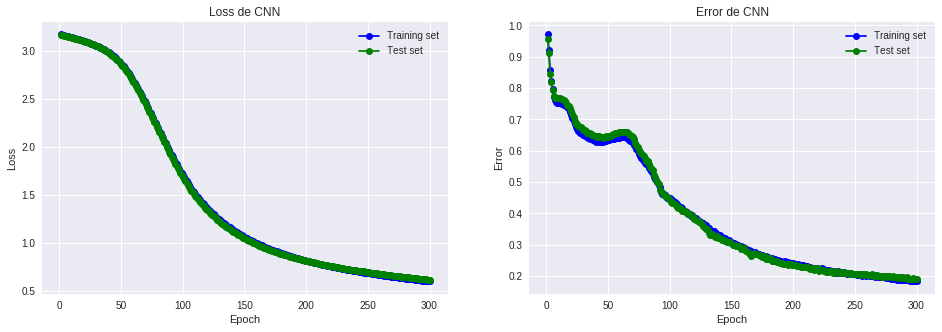

In [27]:
plot(model_fit.history)

Finalmente, se presentan el error y función de pérdida del entrenamiento y prueba por epoch, donde se ve que tienen un comportamiento muy similar, por lo que se podría pensar que las características que la red extrajo del conjunto de entrenamiento, son justamente las que se encuentran en el conjunto prueba.

Ahora, probando con otro oprimizador como RMSprop, con la misma tasa de aprendizaje $0.001$ y un decay de $1e-3$

In [30]:
model2 = Sequential()
model2.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
model2.add(Activation('relu'))
model2.add(Dense(400, kernel_initializer='uniform'))
model2.add(Activation('relu'))
model2.add(Dense(200))
model2.add(Activation('relu'))
model2.add(Dense(24, activation='softmax'))
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               1800      
_________________________________________________________________
activation_4 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 400)               80400     
_________________________________________________________________
activation_5 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               80200     
_________________________________________________________________
activation_6 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                4824      
Total para

In [0]:
rms = rmsprop(lr=0.001, decay=1e-3)
model2.compile(optimizer=rms,loss='categorical_crossentropy', metrics=['acc'])

In [36]:
model_fit_rms = model2.fit(X_train_scaled, Y_train, epochs=300, verbose=1, validation_data=(X_test_scaled, Y_test), shuffle=True)

Train on 4620 samples, validate on 1980 samples
Epoch 1/300
4620/4620 [==============================] - 1s 256us/step - loss: 1.3305 - acc: 0.5874 - val_loss: 0.8018 - val_acc: 0.7207
Epoch 2/300
4620/4620 [==============================] - 1s 220us/step - loss: 0.6808 - acc: 0.7690 - val_loss: 0.6445 - val_acc: 0.7833
Epoch 3/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.5270 - acc: 0.8262 - val_loss: 0.5099 - val_acc: 0.8359
Epoch 4/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.4197 - acc: 0.8649 - val_loss: 0.4303 - val_acc: 0.8505
Epoch 5/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.3654 - acc: 0.8818 - val_loss: 0.4670 - val_acc: 0.8328
Epoch 6/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.3194 - acc: 0.8987 - val_loss: 0.3606 - val_acc: 0.8828
Epoch 7/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.2835 - acc: 0.9121 - val_loss: 0.3297 - val_acc: 

4620/4620 [==============================] - 1s 237us/step - loss: 0.2434 - acc: 0.9245 - val_loss: 0.2817 - val_acc: 0.9035
Epoch 10/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.2230 - acc: 0.9299 - val_loss: 0.2897 - val_acc: 0.9045
Epoch 11/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.2111 - acc: 0.9331 - val_loss: 0.2468 - val_acc: 0.9197
Epoch 12/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.1993 - acc: 0.9359 - val_loss: 0.2561 - val_acc: 0.9081
Epoch 13/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.1871 - acc: 0.9398 - val_loss: 0.2195 - val_acc: 0.9268
Epoch 14/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.1790 - acc: 0.9465 - val_loss: 0.2353 - val_acc: 0.9207
Epoch 15/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.1701 - acc: 0.9468 - val_loss: 0.2244 - val_acc: 0.9263
Epoch 16/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 234us/step - loss: 0.1551 - acc: 0.9535 - val_loss: 0.2490 - val_acc: 0.9247
Epoch 18/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.1484 - acc: 0.9561 - val_loss: 0.1982 - val_acc: 0.9343
Epoch 19/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.1437 - acc: 0.9578 - val_loss: 0.1930 - val_acc: 0.9399
Epoch 20/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.1367 - acc: 0.9602 - val_loss: 0.2072 - val_acc: 0.9343
Epoch 21/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.1335 - acc: 0.9628 - val_loss: 0.1975 - val_acc: 0.9374
Epoch 22/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.1293 - acc: 0.9636 - val_loss: 0.1788 - val_acc: 0.9429
Epoch 23/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.1279 - acc: 0.9628 - val_loss: 0.1805 - val_acc: 0.9424
Epoch 24/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 233us/step - loss: 0.1171 - acc: 0.9690 - val_loss: 0.1687 - val_acc: 0.9490
Epoch 26/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.1169 - acc: 0.9665 - val_loss: 0.1683 - val_acc: 0.9439
Epoch 27/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.1144 - acc: 0.9690 - val_loss: 0.1650 - val_acc: 0.9455
Epoch 28/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.1117 - acc: 0.9706 - val_loss: 0.1683 - val_acc: 0.9465
Epoch 29/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.1091 - acc: 0.9710 - val_loss: 0.1653 - val_acc: 0.9449
Epoch 30/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.1062 - acc: 0.9721 - val_loss: 0.1581 - val_acc: 0.9500
Epoch 31/300
4620/4620 [==============================] - 1s 229us/step - loss: 0.1017 - acc: 0.9729 - val_loss: 0.1809 - val_acc: 0.9409
Epoch 32/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 227us/step - loss: 0.1005 - acc: 0.9745 - val_loss: 0.1662 - val_acc: 0.9495
Epoch 34/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0963 - acc: 0.9766 - val_loss: 0.1642 - val_acc: 0.9460
Epoch 35/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0954 - acc: 0.9784 - val_loss: 0.1546 - val_acc: 0.9520
Epoch 36/300
4620/4620 [==============================] - 1s 229us/step - loss: 0.0939 - acc: 0.9764 - val_loss: 0.1507 - val_acc: 0.9540
Epoch 37/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0937 - acc: 0.9781 - val_loss: 0.1511 - val_acc: 0.9505
Epoch 38/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0919 - acc: 0.9777 - val_loss: 0.1517 - val_acc: 0.9480
Epoch 39/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0889 - acc: 0.9799 - val_loss: 0.1518 - val_acc: 0.9515
Epoch 40/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 228us/step - loss: 0.0865 - acc: 0.9794 - val_loss: 0.1539 - val_acc: 0.9475
Epoch 42/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0861 - acc: 0.9812 - val_loss: 0.1525 - val_acc: 0.9500
Epoch 43/300
4620/4620 [==============================] - 1s 226us/step - loss: 0.0849 - acc: 0.9816 - val_loss: 0.1512 - val_acc: 0.9530
Epoch 44/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0829 - acc: 0.9825 - val_loss: 0.1530 - val_acc: 0.9490
Epoch 45/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0829 - acc: 0.9818 - val_loss: 0.1457 - val_acc: 0.9510
Epoch 46/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0821 - acc: 0.9818 - val_loss: 0.1493 - val_acc: 0.9515
Epoch 47/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0808 - acc: 0.9818 - val_loss: 0.1429 - val_acc: 0.9571
Epoch 48/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 228us/step - loss: 0.0785 - acc: 0.9827 - val_loss: 0.1564 - val_acc: 0.9465
Epoch 50/300
4620/4620 [==============================] - 1s 228us/step - loss: 0.0781 - acc: 0.9810 - val_loss: 0.1446 - val_acc: 0.9515
Epoch 51/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0756 - acc: 0.9838 - val_loss: 0.1468 - val_acc: 0.9540
Epoch 52/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0771 - acc: 0.9833 - val_loss: 0.1366 - val_acc: 0.9571
Epoch 53/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0742 - acc: 0.9840 - val_loss: 0.1397 - val_acc: 0.9556
Epoch 54/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0738 - acc: 0.9831 - val_loss: 0.1473 - val_acc: 0.9545
Epoch 55/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0738 - acc: 0.9829 - val_loss: 0.1382 - val_acc: 0.9525
Epoch 56/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 233us/step - loss: 0.0727 - acc: 0.9825 - val_loss: 0.1426 - val_acc: 0.9551
Epoch 58/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.0720 - acc: 0.9855 - val_loss: 0.1482 - val_acc: 0.9495
Epoch 59/300
4620/4620 [==============================] - 1s 222us/step - loss: 0.0713 - acc: 0.9835 - val_loss: 0.1387 - val_acc: 0.9561
Epoch 60/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0701 - acc: 0.9844 - val_loss: 0.1473 - val_acc: 0.9525
Epoch 61/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0702 - acc: 0.9864 - val_loss: 0.1403 - val_acc: 0.9581
Epoch 62/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0694 - acc: 0.9861 - val_loss: 0.1458 - val_acc: 0.9520
Epoch 63/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0693 - acc: 0.9866 - val_loss: 0.1410 - val_acc: 0.9566
Epoch 64/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 228us/step - loss: 0.0672 - acc: 0.9866 - val_loss: 0.1403 - val_acc: 0.9551
Epoch 66/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0674 - acc: 0.9870 - val_loss: 0.1356 - val_acc: 0.9540
Epoch 67/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0660 - acc: 0.9874 - val_loss: 0.1428 - val_acc: 0.9545
Epoch 68/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0651 - acc: 0.9870 - val_loss: 0.1396 - val_acc: 0.9576
Epoch 69/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0653 - acc: 0.9868 - val_loss: 0.1306 - val_acc: 0.9561
Epoch 70/300
4620/4620 [==============================] - 1s 229us/step - loss: 0.0642 - acc: 0.9866 - val_loss: 0.1411 - val_acc: 0.9520
Epoch 71/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0640 - acc: 0.9874 - val_loss: 0.1348 - val_acc: 0.9561
Epoch 72/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 227us/step - loss: 0.0638 - acc: 0.9870 - val_loss: 0.1346 - val_acc: 0.9601
Epoch 74/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0631 - acc: 0.9879 - val_loss: 0.1292 - val_acc: 0.9606
Epoch 75/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0628 - acc: 0.9872 - val_loss: 0.1353 - val_acc: 0.9556
Epoch 76/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0620 - acc: 0.9870 - val_loss: 0.1462 - val_acc: 0.9525
Epoch 77/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0612 - acc: 0.9883 - val_loss: 0.1377 - val_acc: 0.9540
Epoch 78/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0618 - acc: 0.9861 - val_loss: 0.1320 - val_acc: 0.9601
Epoch 79/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0607 - acc: 0.9883 - val_loss: 0.1358 - val_acc: 0.9530
Epoch 80/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 234us/step - loss: 0.0599 - acc: 0.9885 - val_loss: 0.1425 - val_acc: 0.9545
Epoch 82/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0597 - acc: 0.9881 - val_loss: 0.1351 - val_acc: 0.9591
Epoch 83/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0597 - acc: 0.9881 - val_loss: 0.1422 - val_acc: 0.9540
Epoch 84/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0599 - acc: 0.9881 - val_loss: 0.1385 - val_acc: 0.9556
Epoch 85/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0577 - acc: 0.9890 - val_loss: 0.1417 - val_acc: 0.9540
Epoch 86/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0584 - acc: 0.9892 - val_loss: 0.1393 - val_acc: 0.9535
Epoch 87/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0589 - acc: 0.9887 - val_loss: 0.1414 - val_acc: 0.9540
Epoch 88/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 225us/step - loss: 0.0577 - acc: 0.9874 - val_loss: 0.1348 - val_acc: 0.9556
Epoch 90/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0574 - acc: 0.9890 - val_loss: 0.1314 - val_acc: 0.9581
Epoch 91/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0570 - acc: 0.9887 - val_loss: 0.1469 - val_acc: 0.9535
Epoch 92/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0570 - acc: 0.9879 - val_loss: 0.1309 - val_acc: 0.9591
Epoch 93/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0567 - acc: 0.9887 - val_loss: 0.1366 - val_acc: 0.9586
Epoch 94/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0563 - acc: 0.9887 - val_loss: 0.1293 - val_acc: 0.9586
Epoch 95/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0556 - acc: 0.9903 - val_loss: 0.1320 - val_acc: 0.9591
Epoch 96/300
4620/4620 [=======================

4620/4620 [==============================] - 1s 244us/step - loss: 0.0554 - acc: 0.9898 - val_loss: 0.1383 - val_acc: 0.9556
Epoch 98/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0552 - acc: 0.9903 - val_loss: 0.1346 - val_acc: 0.9596
Epoch 99/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0546 - acc: 0.9905 - val_loss: 0.1331 - val_acc: 0.9596
Epoch 100/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0545 - acc: 0.9894 - val_loss: 0.1320 - val_acc: 0.9606
Epoch 101/300
4620/4620 [==============================] - 1s 240us/step - loss: 0.0545 - acc: 0.9903 - val_loss: 0.1316 - val_acc: 0.9591
Epoch 102/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0539 - acc: 0.9903 - val_loss: 0.1387 - val_acc: 0.9571
Epoch 103/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0536 - acc: 0.9894 - val_loss: 0.1370 - val_acc: 0.9530
Epoch 104/300
4620/4620 [==================

4620/4620 [==============================] - 1s 240us/step - loss: 0.0529 - acc: 0.9894 - val_loss: 0.1383 - val_acc: 0.9566
Epoch 106/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0526 - acc: 0.9903 - val_loss: 0.1334 - val_acc: 0.9601
Epoch 107/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0532 - acc: 0.9900 - val_loss: 0.1299 - val_acc: 0.9616
Epoch 108/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0528 - acc: 0.9905 - val_loss: 0.1276 - val_acc: 0.9606
Epoch 109/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0526 - acc: 0.9909 - val_loss: 0.1359 - val_acc: 0.9586
Epoch 110/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0519 - acc: 0.9911 - val_loss: 0.1363 - val_acc: 0.9566
Epoch 111/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0523 - acc: 0.9894 - val_loss: 0.1312 - val_acc: 0.9586
Epoch 112/300
4620/4620 [================

4620/4620 [==============================] - 1s 236us/step - loss: 0.0518 - acc: 0.9918 - val_loss: 0.1364 - val_acc: 0.9586
Epoch 114/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0514 - acc: 0.9905 - val_loss: 0.1276 - val_acc: 0.9611
Epoch 115/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0510 - acc: 0.9909 - val_loss: 0.1301 - val_acc: 0.9611
Epoch 116/300
4620/4620 [==============================] - 1s 228us/step - loss: 0.0502 - acc: 0.9903 - val_loss: 0.1265 - val_acc: 0.9606
Epoch 117/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0511 - acc: 0.9916 - val_loss: 0.1317 - val_acc: 0.9591
Epoch 118/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0505 - acc: 0.9903 - val_loss: 0.1315 - val_acc: 0.9591
Epoch 119/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0506 - acc: 0.9913 - val_loss: 0.1324 - val_acc: 0.9606
Epoch 120/300
4620/4620 [================

4620/4620 [==============================] - 1s 237us/step - loss: 0.0504 - acc: 0.9911 - val_loss: 0.1347 - val_acc: 0.9586
Epoch 122/300
4620/4620 [==============================] - 1s 241us/step - loss: 0.0499 - acc: 0.9922 - val_loss: 0.1306 - val_acc: 0.9591
Epoch 123/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.0501 - acc: 0.9909 - val_loss: 0.1301 - val_acc: 0.9596
Epoch 124/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0497 - acc: 0.9916 - val_loss: 0.1282 - val_acc: 0.9616
Epoch 125/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0491 - acc: 0.9909 - val_loss: 0.1292 - val_acc: 0.9616
Epoch 126/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0493 - acc: 0.9918 - val_loss: 0.1336 - val_acc: 0.9581
Epoch 127/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0490 - acc: 0.9911 - val_loss: 0.1383 - val_acc: 0.9566
Epoch 128/300
4620/4620 [================

4620/4620 [==============================] - 1s 237us/step - loss: 0.0488 - acc: 0.9918 - val_loss: 0.1266 - val_acc: 0.9631
Epoch 130/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0485 - acc: 0.9922 - val_loss: 0.1330 - val_acc: 0.9616
Epoch 131/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.0489 - acc: 0.9920 - val_loss: 0.1307 - val_acc: 0.9611
Epoch 132/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0486 - acc: 0.9918 - val_loss: 0.1280 - val_acc: 0.9616
Epoch 133/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0482 - acc: 0.9911 - val_loss: 0.1291 - val_acc: 0.9616
Epoch 134/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0481 - acc: 0.9918 - val_loss: 0.1316 - val_acc: 0.9601
Epoch 135/300
4620/4620 [==============================] - 1s 229us/step - loss: 0.0486 - acc: 0.9918 - val_loss: 0.1321 - val_acc: 0.9586
Epoch 136/300
4620/4620 [================

4620/4620 [==============================] - 1s 233us/step - loss: 0.0478 - acc: 0.9929 - val_loss: 0.1324 - val_acc: 0.9596
Epoch 138/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0477 - acc: 0.9913 - val_loss: 0.1319 - val_acc: 0.9591
Epoch 139/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0467 - acc: 0.9935 - val_loss: 0.1342 - val_acc: 0.9601
Epoch 140/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0475 - acc: 0.9918 - val_loss: 0.1302 - val_acc: 0.9596
Epoch 141/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0474 - acc: 0.9920 - val_loss: 0.1361 - val_acc: 0.9606
Epoch 142/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0473 - acc: 0.9935 - val_loss: 0.1331 - val_acc: 0.9596
Epoch 143/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0468 - acc: 0.9926 - val_loss: 0.1338 - val_acc: 0.9586
Epoch 144/300
4620/4620 [================

4620/4620 [==============================] - 1s 231us/step - loss: 0.0463 - acc: 0.9918 - val_loss: 0.1288 - val_acc: 0.9586
Epoch 146/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0468 - acc: 0.9922 - val_loss: 0.1334 - val_acc: 0.9596
Epoch 147/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0464 - acc: 0.9926 - val_loss: 0.1342 - val_acc: 0.9601
Epoch 148/300
4620/4620 [==============================] - 1s 226us/step - loss: 0.0464 - acc: 0.9920 - val_loss: 0.1348 - val_acc: 0.9591
Epoch 149/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0462 - acc: 0.9920 - val_loss: 0.1323 - val_acc: 0.9596
Epoch 150/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0462 - acc: 0.9922 - val_loss: 0.1319 - val_acc: 0.9626
Epoch 151/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0454 - acc: 0.9924 - val_loss: 0.1357 - val_acc: 0.9601
Epoch 152/300
4620/4620 [================

4620/4620 [==============================] - 1s 233us/step - loss: 0.0461 - acc: 0.9926 - val_loss: 0.1305 - val_acc: 0.9611
Epoch 154/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0455 - acc: 0.9931 - val_loss: 0.1329 - val_acc: 0.9616
Epoch 155/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0457 - acc: 0.9922 - val_loss: 0.1337 - val_acc: 0.9596
Epoch 156/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0455 - acc: 0.9931 - val_loss: 0.1329 - val_acc: 0.9606
Epoch 157/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0453 - acc: 0.9933 - val_loss: 0.1346 - val_acc: 0.9586
Epoch 158/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0451 - acc: 0.9931 - val_loss: 0.1320 - val_acc: 0.9596
Epoch 159/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0447 - acc: 0.9935 - val_loss: 0.1350 - val_acc: 0.9601
Epoch 160/300
4620/4620 [================

4620/4620 [==============================] - 1s 230us/step - loss: 0.0451 - acc: 0.9931 - val_loss: 0.1313 - val_acc: 0.9601
Epoch 162/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0449 - acc: 0.9926 - val_loss: 0.1290 - val_acc: 0.9611
Epoch 163/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0448 - acc: 0.9931 - val_loss: 0.1294 - val_acc: 0.9611
Epoch 164/300
4620/4620 [==============================] - 1s 228us/step - loss: 0.0447 - acc: 0.9929 - val_loss: 0.1294 - val_acc: 0.9591
Epoch 165/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0447 - acc: 0.9931 - val_loss: 0.1274 - val_acc: 0.9616
Epoch 166/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0442 - acc: 0.9931 - val_loss: 0.1308 - val_acc: 0.9596
Epoch 167/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0446 - acc: 0.9931 - val_loss: 0.1296 - val_acc: 0.9606
Epoch 168/300
4620/4620 [================

4620/4620 [==============================] - 1s 230us/step - loss: 0.0443 - acc: 0.9931 - val_loss: 0.1312 - val_acc: 0.9601
Epoch 170/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0443 - acc: 0.9929 - val_loss: 0.1336 - val_acc: 0.9591
Epoch 171/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0440 - acc: 0.9926 - val_loss: 0.1332 - val_acc: 0.9601
Epoch 172/300
4620/4620 [==============================] - 1s 240us/step - loss: 0.0435 - acc: 0.9926 - val_loss: 0.1309 - val_acc: 0.9601
Epoch 173/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0441 - acc: 0.9929 - val_loss: 0.1328 - val_acc: 0.9606
Epoch 174/300
4620/4620 [==============================] - 1s 241us/step - loss: 0.0437 - acc: 0.9937 - val_loss: 0.1345 - val_acc: 0.9601
Epoch 175/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0438 - acc: 0.9933 - val_loss: 0.1346 - val_acc: 0.9601
Epoch 176/300
4620/4620 [================

4620/4620 [==============================] - 1s 237us/step - loss: 0.0437 - acc: 0.9929 - val_loss: 0.1297 - val_acc: 0.9631
Epoch 178/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0437 - acc: 0.9933 - val_loss: 0.1367 - val_acc: 0.9596
Epoch 179/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0432 - acc: 0.9933 - val_loss: 0.1352 - val_acc: 0.9581
Epoch 180/300
4620/4620 [==============================] - 1s 241us/step - loss: 0.0434 - acc: 0.9935 - val_loss: 0.1306 - val_acc: 0.9611
Epoch 181/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0429 - acc: 0.9935 - val_loss: 0.1315 - val_acc: 0.9616
Epoch 182/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0430 - acc: 0.9937 - val_loss: 0.1363 - val_acc: 0.9586
Epoch 183/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0431 - acc: 0.9935 - val_loss: 0.1311 - val_acc: 0.9611
Epoch 184/300
4620/4620 [================

4620/4620 [==============================] - 1s 238us/step - loss: 0.0429 - acc: 0.9933 - val_loss: 0.1298 - val_acc: 0.9616
Epoch 186/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0431 - acc: 0.9937 - val_loss: 0.1345 - val_acc: 0.9606
Epoch 187/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0427 - acc: 0.9939 - val_loss: 0.1340 - val_acc: 0.9596
Epoch 188/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0424 - acc: 0.9937 - val_loss: 0.1338 - val_acc: 0.9586
Epoch 189/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0426 - acc: 0.9933 - val_loss: 0.1309 - val_acc: 0.9611
Epoch 190/300
4620/4620 [==============================] - 1s 240us/step - loss: 0.0424 - acc: 0.9929 - val_loss: 0.1327 - val_acc: 0.9606
Epoch 191/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0427 - acc: 0.9933 - val_loss: 0.1339 - val_acc: 0.9596
Epoch 192/300
4620/4620 [================

4620/4620 [==============================] - 1s 232us/step - loss: 0.0422 - acc: 0.9929 - val_loss: 0.1321 - val_acc: 0.9611
Epoch 194/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0421 - acc: 0.9933 - val_loss: 0.1322 - val_acc: 0.9591
Epoch 195/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0422 - acc: 0.9939 - val_loss: 0.1309 - val_acc: 0.9606
Epoch 196/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0421 - acc: 0.9942 - val_loss: 0.1335 - val_acc: 0.9596
Epoch 197/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0420 - acc: 0.9933 - val_loss: 0.1325 - val_acc: 0.9601
Epoch 198/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0422 - acc: 0.9935 - val_loss: 0.1334 - val_acc: 0.9601
Epoch 199/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0416 - acc: 0.9939 - val_loss: 0.1334 - val_acc: 0.9601
Epoch 200/300
4620/4620 [================

4620/4620 [==============================] - 1s 236us/step - loss: 0.0417 - acc: 0.9946 - val_loss: 0.1365 - val_acc: 0.9596
Epoch 202/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0415 - acc: 0.9939 - val_loss: 0.1364 - val_acc: 0.9596
Epoch 203/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0416 - acc: 0.9933 - val_loss: 0.1340 - val_acc: 0.9601
Epoch 204/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0413 - acc: 0.9942 - val_loss: 0.1369 - val_acc: 0.9601
Epoch 205/300
4620/4620 [==============================] - 1s 240us/step - loss: 0.0417 - acc: 0.9931 - val_loss: 0.1369 - val_acc: 0.9606
Epoch 206/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0413 - acc: 0.9942 - val_loss: 0.1378 - val_acc: 0.9601
Epoch 207/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0405 - acc: 0.9935 - val_loss: 0.1373 - val_acc: 0.9586
Epoch 208/300
4620/4620 [================

4620/4620 [==============================] - 1s 241us/step - loss: 0.0412 - acc: 0.9942 - val_loss: 0.1337 - val_acc: 0.9621
Epoch 210/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0415 - acc: 0.9937 - val_loss: 0.1346 - val_acc: 0.9606
Epoch 211/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.0411 - acc: 0.9935 - val_loss: 0.1328 - val_acc: 0.9596
Epoch 212/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0409 - acc: 0.9937 - val_loss: 0.1334 - val_acc: 0.9601
Epoch 213/300
4620/4620 [==============================] - 1s 226us/step - loss: 0.0412 - acc: 0.9933 - val_loss: 0.1353 - val_acc: 0.9586
Epoch 214/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0412 - acc: 0.9939 - val_loss: 0.1341 - val_acc: 0.9606
Epoch 215/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0412 - acc: 0.9933 - val_loss: 0.1354 - val_acc: 0.9601
Epoch 216/300
4620/4620 [================

4620/4620 [==============================] - 1s 230us/step - loss: 0.0408 - acc: 0.9939 - val_loss: 0.1342 - val_acc: 0.9601
Epoch 218/300
4620/4620 [==============================] - 1s 228us/step - loss: 0.0405 - acc: 0.9939 - val_loss: 0.1336 - val_acc: 0.9611
Epoch 219/300
4620/4620 [==============================] - 1s 229us/step - loss: 0.0407 - acc: 0.9939 - val_loss: 0.1320 - val_acc: 0.9601
Epoch 220/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0402 - acc: 0.9946 - val_loss: 0.1327 - val_acc: 0.9606
Epoch 221/300
4620/4620 [==============================] - 1s 229us/step - loss: 0.0402 - acc: 0.9944 - val_loss: 0.1356 - val_acc: 0.9601
Epoch 222/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0404 - acc: 0.9944 - val_loss: 0.1380 - val_acc: 0.9586
Epoch 223/300
4620/4620 [==============================] - 1s 225us/step - loss: 0.0408 - acc: 0.9935 - val_loss: 0.1340 - val_acc: 0.9611
Epoch 224/300
4620/4620 [================

4620/4620 [==============================] - 1s 236us/step - loss: 0.0406 - acc: 0.9942 - val_loss: 0.1342 - val_acc: 0.9616
Epoch 226/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0403 - acc: 0.9937 - val_loss: 0.1364 - val_acc: 0.9611
Epoch 227/300
4620/4620 [==============================] - 1s 226us/step - loss: 0.0403 - acc: 0.9946 - val_loss: 0.1361 - val_acc: 0.9601
Epoch 228/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0403 - acc: 0.9942 - val_loss: 0.1346 - val_acc: 0.9601
Epoch 229/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0402 - acc: 0.9942 - val_loss: 0.1350 - val_acc: 0.9611
Epoch 230/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0400 - acc: 0.9948 - val_loss: 0.1343 - val_acc: 0.9596
Epoch 231/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0402 - acc: 0.9946 - val_loss: 0.1322 - val_acc: 0.9606
Epoch 232/300
4620/4620 [================

4620/4620 [==============================] - 1s 232us/step - loss: 0.0397 - acc: 0.9946 - val_loss: 0.1370 - val_acc: 0.9596
Epoch 234/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0397 - acc: 0.9944 - val_loss: 0.1329 - val_acc: 0.9601
Epoch 235/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0403 - acc: 0.9942 - val_loss: 0.1376 - val_acc: 0.9596
Epoch 236/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0398 - acc: 0.9944 - val_loss: 0.1382 - val_acc: 0.9586
Epoch 237/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0399 - acc: 0.9942 - val_loss: 0.1326 - val_acc: 0.9606
Epoch 238/300
4620/4620 [==============================] - 1s 228us/step - loss: 0.0397 - acc: 0.9946 - val_loss: 0.1328 - val_acc: 0.9611
Epoch 239/300
4620/4620 [==============================] - 1s 226us/step - loss: 0.0396 - acc: 0.9944 - val_loss: 0.1364 - val_acc: 0.9606
Epoch 240/300
4620/4620 [================

4620/4620 [==============================] - 1s 234us/step - loss: 0.0397 - acc: 0.9937 - val_loss: 0.1360 - val_acc: 0.9586
Epoch 242/300
4620/4620 [==============================] - 1s 229us/step - loss: 0.0397 - acc: 0.9946 - val_loss: 0.1340 - val_acc: 0.9606
Epoch 243/300
4620/4620 [==============================] - 1s 237us/step - loss: 0.0395 - acc: 0.9946 - val_loss: 0.1352 - val_acc: 0.9596
Epoch 244/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0394 - acc: 0.9950 - val_loss: 0.1336 - val_acc: 0.9611
Epoch 245/300
4620/4620 [==============================] - 1s 240us/step - loss: 0.0392 - acc: 0.9950 - val_loss: 0.1302 - val_acc: 0.9601
Epoch 246/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0397 - acc: 0.9942 - val_loss: 0.1333 - val_acc: 0.9591
Epoch 247/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0397 - acc: 0.9944 - val_loss: 0.1321 - val_acc: 0.9611
Epoch 248/300
4620/4620 [================

4620/4620 [==============================] - 1s 233us/step - loss: 0.0390 - acc: 0.9950 - val_loss: 0.1347 - val_acc: 0.9601
Epoch 250/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0392 - acc: 0.9952 - val_loss: 0.1357 - val_acc: 0.9586
Epoch 251/300
4620/4620 [==============================] - 1s 226us/step - loss: 0.0391 - acc: 0.9950 - val_loss: 0.1335 - val_acc: 0.9606
Epoch 252/300
4620/4620 [==============================] - 1s 221us/step - loss: 0.0387 - acc: 0.9944 - val_loss: 0.1373 - val_acc: 0.9591
Epoch 253/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0391 - acc: 0.9950 - val_loss: 0.1331 - val_acc: 0.9586
Epoch 254/300
4620/4620 [==============================] - 1s 228us/step - loss: 0.0392 - acc: 0.9946 - val_loss: 0.1352 - val_acc: 0.9601
Epoch 255/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0392 - acc: 0.9948 - val_loss: 0.1318 - val_acc: 0.9606
Epoch 256/300
4620/4620 [================

4620/4620 [==============================] - 1s 231us/step - loss: 0.0388 - acc: 0.9950 - val_loss: 0.1357 - val_acc: 0.9586
Epoch 258/300
4620/4620 [==============================] - 1s 229us/step - loss: 0.0391 - acc: 0.9942 - val_loss: 0.1330 - val_acc: 0.9601
Epoch 259/300
4620/4620 [==============================] - 1s 230us/step - loss: 0.0389 - acc: 0.9948 - val_loss: 0.1362 - val_acc: 0.9596
Epoch 260/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0389 - acc: 0.9950 - val_loss: 0.1358 - val_acc: 0.9601
Epoch 261/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0390 - acc: 0.9942 - val_loss: 0.1351 - val_acc: 0.9596
Epoch 262/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0388 - acc: 0.9942 - val_loss: 0.1346 - val_acc: 0.9596
Epoch 263/300
4620/4620 [==============================] - 1s 242us/step - loss: 0.0388 - acc: 0.9946 - val_loss: 0.1354 - val_acc: 0.9606
Epoch 264/300
4620/4620 [================

4620/4620 [==============================] - 1s 237us/step - loss: 0.0384 - acc: 0.9944 - val_loss: 0.1347 - val_acc: 0.9606
Epoch 266/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0382 - acc: 0.9950 - val_loss: 0.1349 - val_acc: 0.9586
Epoch 267/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.0386 - acc: 0.9950 - val_loss: 0.1346 - val_acc: 0.9591
Epoch 268/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0388 - acc: 0.9952 - val_loss: 0.1364 - val_acc: 0.9601
Epoch 269/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0383 - acc: 0.9946 - val_loss: 0.1335 - val_acc: 0.9606
Epoch 270/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0383 - acc: 0.9948 - val_loss: 0.1350 - val_acc: 0.9601
Epoch 271/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0383 - acc: 0.9957 - val_loss: 0.1377 - val_acc: 0.9591
Epoch 272/300
4620/4620 [================

4620/4620 [==============================] - 1s 243us/step - loss: 0.0387 - acc: 0.9948 - val_loss: 0.1382 - val_acc: 0.9581
Epoch 274/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0382 - acc: 0.9950 - val_loss: 0.1350 - val_acc: 0.9606
Epoch 275/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0382 - acc: 0.9952 - val_loss: 0.1345 - val_acc: 0.9601
Epoch 276/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0380 - acc: 0.9950 - val_loss: 0.1339 - val_acc: 0.9606
Epoch 277/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0381 - acc: 0.9950 - val_loss: 0.1366 - val_acc: 0.9601
Epoch 278/300
4620/4620 [==============================] - 1s 227us/step - loss: 0.0379 - acc: 0.9957 - val_loss: 0.1354 - val_acc: 0.9601
Epoch 279/300
4620/4620 [==============================] - 1s 228us/step - loss: 0.0379 - acc: 0.9948 - val_loss: 0.1347 - val_acc: 0.9596
Epoch 280/300
4620/4620 [================

4620/4620 [==============================] - 1s 226us/step - loss: 0.0378 - acc: 0.9950 - val_loss: 0.1366 - val_acc: 0.9596
Epoch 282/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0383 - acc: 0.9944 - val_loss: 0.1347 - val_acc: 0.9596
Epoch 283/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0377 - acc: 0.9957 - val_loss: 0.1367 - val_acc: 0.9601
Epoch 284/300
4620/4620 [==============================] - 1s 233us/step - loss: 0.0381 - acc: 0.9946 - val_loss: 0.1359 - val_acc: 0.9606
Epoch 285/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0380 - acc: 0.9957 - val_loss: 0.1346 - val_acc: 0.9606
Epoch 286/300
4620/4620 [==============================] - 1s 231us/step - loss: 0.0378 - acc: 0.9950 - val_loss: 0.1342 - val_acc: 0.9601
Epoch 287/300
4620/4620 [==============================] - 1s 232us/step - loss: 0.0378 - acc: 0.9961 - val_loss: 0.1361 - val_acc: 0.9606
Epoch 288/300
4620/4620 [================

4620/4620 [==============================] - 1s 240us/step - loss: 0.0378 - acc: 0.9952 - val_loss: 0.1372 - val_acc: 0.9586
Epoch 290/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0374 - acc: 0.9952 - val_loss: 0.1371 - val_acc: 0.9601
Epoch 291/300
4620/4620 [==============================] - 1s 240us/step - loss: 0.0377 - acc: 0.9955 - val_loss: 0.1358 - val_acc: 0.9601
Epoch 292/300
4620/4620 [==============================] - 1s 242us/step - loss: 0.0378 - acc: 0.9952 - val_loss: 0.1386 - val_acc: 0.9596
Epoch 293/300
4620/4620 [==============================] - 1s 238us/step - loss: 0.0378 - acc: 0.9950 - val_loss: 0.1354 - val_acc: 0.9601
Epoch 294/300
4620/4620 [==============================] - 1s 234us/step - loss: 0.0376 - acc: 0.9952 - val_loss: 0.1374 - val_acc: 0.9596
Epoch 295/300
4620/4620 [==============================] - 1s 235us/step - loss: 0.0375 - acc: 0.9957 - val_loss: 0.1378 - val_acc: 0.9606
Epoch 296/300
4620/4620 [================

4620/4620 [==============================] - 1s 236us/step - loss: 0.0376 - acc: 0.9950 - val_loss: 0.1370 - val_acc: 0.9601
Epoch 298/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.0375 - acc: 0.9955 - val_loss: 0.1374 - val_acc: 0.9586
Epoch 299/300
4620/4620 [==============================] - 1s 239us/step - loss: 0.0374 - acc: 0.9961 - val_loss: 0.1368 - val_acc: 0.9596
Epoch 300/300
4620/4620 [==============================] - 1s 236us/step - loss: 0.0374 - acc: 0.9957 - val_loss: 0.1363 - val_acc: 0.9601


In [37]:
score_rms = model2.evaluate(X_test_scaled, Y_test)
print("Cross entropy loss:", score_rms[0])
print("Accuracy: ", score_rms[1])

1980/1980 [==============================] - 0s 66us/step
Cross entropy loss: 0.1363242324930851
Accuracy:  0.9601010103418369


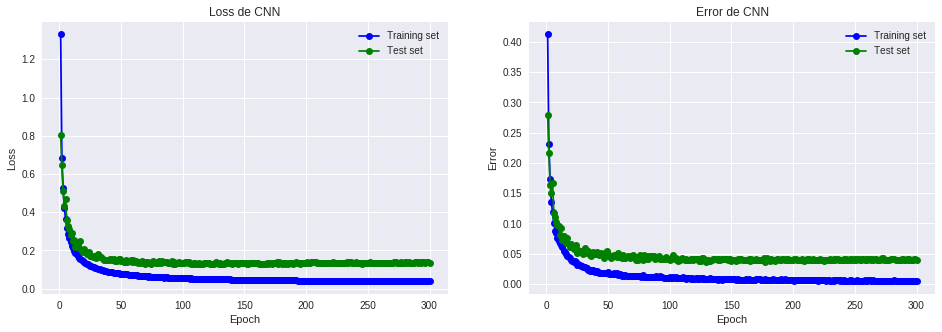

In [38]:
plot(model_fit_rms.history)

Se ve como con este optimizador se obitene un mejor resultado tanto en el conjunto de prueba, con un accuracy del $96\%$, como en el conjunto de entrenamiento que se logra un error y función de entrenamiento muy cercana al cero. Se pude apreciar, como este modelo sufre más de overfitting que el modelo anterior.